This notebook intended to calculate the correlation between percentage of inspections in the Park District, failed for specific feature, for example, litter, and number of litter-related 311 complains made in the window of N days before inspection for the related park

In [1]:
__author__ = "me"
__date__ = "2015_10_13"

%pylab inline
import pandas as pd
import numpy as np
import geopandas as gp

import pylab as plt
import os

import requests
s = requests.get("https://raw.githubusercontent.com/Casyfill/CUSP_templates/master/Py/fbMatplotlibrc.json").json()
plt.rcParams.update(s)


Populating the interactive namespace from numpy and matplotlib


/Users/casy/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:855: UserWarning: svg.embed_char_paths is deprecated and replaced with svg.fonttype; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [35]:
PARQA = os.getenv('PARQA')
path = PARQA + "data/Input/Parks_Data/PIP_InspectionMain.xlsx"

## Reading Data

In [36]:
df = pd.read_excel(path)

In [37]:
df = df[(pd.notnull(df.BeginInspection) ) &  (pd.notnull(df.EndInspection))]

## Parsing dates

In [38]:
df.head(2)

,Prop ID,Season,Round,Date,BeginInspection,EndInspection,Inspection Year,Overall Condition,Cleanliness,VisitorCount,Unacceptable Features,Inspection ID
0,M010-ZN08,Summer,2,2015-06-30,12:29:00,13:24:00,2015,A,A,60,SW,97371
1,M010-143,Summer,2,2015-06-30,13:40:00,13:57:00,2015,A,A,7,NaN,97370


In [39]:
df.Date = pd.to_datetime(df.Date, format='%Y-%m-%d')

,Prop ID,Season,Round,Date,BeginInspection,EndInspection,Inspection Year,Overall Condition,Cleanliness,VisitorCount,Unacceptable Features,Inspection ID
0,M010-ZN08,Summer,2,2015-06-30,12:29:00,13:24:00,2015,A,A,60,SW,97371
1,M010-143,Summer,2,2015-06-30,13:40:00,13:57:00,2015,A,A,7,NaN,97370
2,B065-ZN10,Summer,2,2015-06-30,11:45:00,12:25:00,2015,U,U,29,"LI, WD",97369
3,B169-ZN05B,Summer,2,2015-06-30,10:45:00,11:30:00,2015,A,A,233,NaN,97368
4,M010-ZN10&11,Summer,2,2015-06-30,11:00:00,12:23:00,2015,A,A,55,LW,97367


In [9]:
# g = df[['Date','Prop ID','Overall Condition']].groupby('Prop ID').agg(lambda x: x.tolist()).reset_index()
# g.head(2)

In [10]:
def inRange(d, inspection, marginDays=7):
    '''tells if date is withing margin before the inspection'''
    return inspection - datetime.timedelta(days = marginDays) <=  d <= inspection

In [11]:
### ADD PROP ID to each call trhough calls
### aggregate Calls to Those ratings

In [43]:
inspections = df[['Prop ID','Date', 'Overall Condition', 'Cleanliness','Unacceptable Features']]


## Read matched Calls

In [15]:
lcalls = pd.read_csv(PARQA + 'data/311/311_rPID_litter.csv',index_col=0)[['rParkID','Created Date',]]

In [17]:
lcalls['Created Date'] = pd.to_datetime(lcalls['Created Date'])

In [18]:
lcalls.head()

,rParkID,Created Date
163,M219,2010-12-25 01:47:32
170,M042-ZN06,2010-12-23 15:30:49
228,M219,2010-12-20 11:08:40
229,X104-03,2010-12-20 10:36:16
230,X104-02,2010-12-20 10:36:16


In [113]:
def countCalls(z, d = 7):
    acalls = lcalls[lcalls.rParkID==z['Prop ID']]

    inD = lcalls['Created Date'].apply(lambda x: inRange(x,z.Date, marginDays=d))
#     print '!'
    return len(acalls[inD])

In [ ]:
#### THIS TAKES TONS OF TIME: BEWARE!!  ########
cl_inspections = inspections[inspections['Cleanliness']=='U']

In [114]:
cl_inspections['weekCalls'] = cl_inspections.apply(countCalls, axis=1)

/Users/casy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [115]:
#### THIS TAKES TONS OF TIME: BEWARE!!  ########
cl_inspections['monthCalls'] = cl_inspections.apply(lambda x: countCalls(x,d=30), axis=1)

/Users/casy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


## Aggregating to Districts

In [70]:
# inspections['l_calls'] = inspections.apply(countCalls, axis=1)

In [117]:
distrs = pd.read_csv(PARQA + '/data/PID_PDistr.csv', index_col=0)

In [129]:
inspPerDistrict = pd.DataFrame(inspections.merge(distrs, how='left', on= 'Prop ID').distr.value_counts())
fInspPerDistrict = pd.DataFrame(cl_inspections.merge(distrs, how='left', on= 'Prop ID').distr.value_counts())

In [122]:
callsPerDistrict = cl_inspections.merge(distrs, how='left', on='Prop ID')[['distr','monthCalls','weekCalls']].groupby('distr').agg(sum)

In [125]:
r = pd.concat([cl_inspections, inspPerDistrict, fInspPerDistrict ],axis=1)

In [132]:
r.columns = ['monthCalls','weekCalls','total','failed']
r['percent'] = 100.0*r.failed/r.total

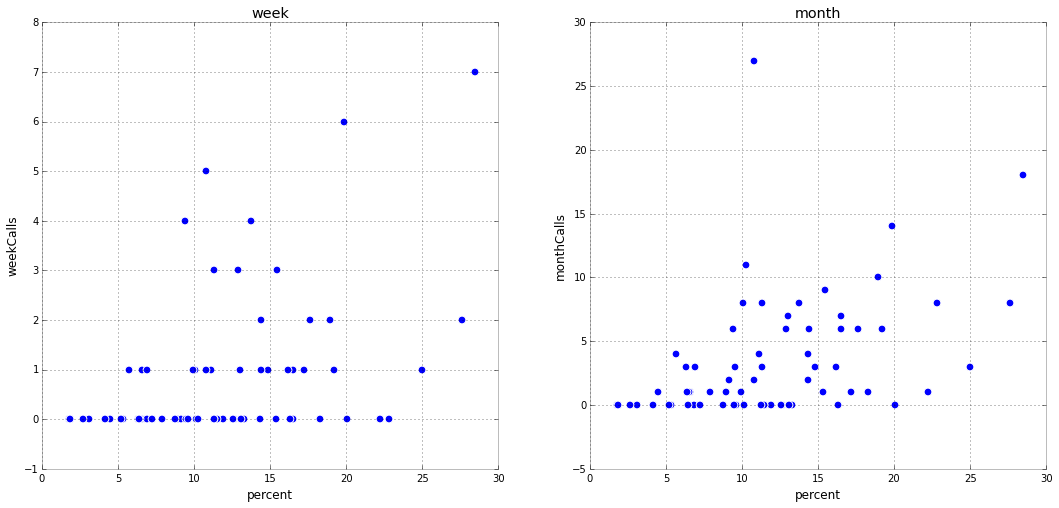

In [137]:
fig, axes = plt.subplots(1,2, figsize=(18,8))

r.plot(kind='scatter', x='percent',y='weekCalls',ax=axes[0],title='week', s=60);
r.plot(kind='scatter', x='percent',y='monthCalls',ax=axes[1],title='month', s=60);
plt.title('311 calls in finite time period before failed inspection\n vs percentage of failed inspections per district')

## Litter specificly

In [146]:
litter = pd.read_csv(PARQA + "data/All_Inspections.csv",index_col=0)
litter = litter[litter.Litter==1]
litter.Date = pd.to_datetime(litter.Date, format='%Y-%m-%d')


In [147]:
litter.columns

Index([u'Prop ID', u'PropNum', u'Boro', u'GISBoro', u'District', u'Prop Name',
       u'Site Name', u'Prop Location', u'Site Location', u'ACRES', u'Category',
       u'Sub-Category', u'Comments', u'Rated', u'Reason Not Rated',
       u'Sub-Properties Rated', u'Sub-Property', u'COMMUNITYBOARD',
       u'TypeCategory', u'Season', u'Round', u'Date', u'BeginInspection',
       u'EndInspection', u'Inspection Year', u'Overall Condition',
       u'Cleanliness', u'VisitorCount', u'Unacceptable Features',
       u'Inspection ID', u'PID_base', u'Athletic Fields', u'Benches',
       u'Fences', u'Glass', u'Graffiti', u'Horticultural Areas', u'Ice',
       u'Lawns', u'Litter', u'Paved Surfaces', u'Play Equipment',
       u'Safety Surface', u'Sidewalks', u'Trails', u'Trees', u'Water Bodies',
       u'Weeds', u'Adjusted Acres', u'ZIPCODE'],
      dtype='object')

In [158]:
litter.Cleanliness.value_counts()

A    5867
U    1862
N       1
Name: Cleanliness, dtype: int64

In [148]:
litter['lweekCalls'] = litter.apply(countCalls, axis=1)
litter['monthCalls'] = litter.apply(lambda x: countCalls(x,d=30), axis=1)

In [149]:
litter

,Prop ID,PropNum,Boro,GISBoro,District,Prop Name,Site Name,Prop Location,Site Location,ACRES,...,Safety Surface,Sidewalks,Trails,Trees,Water Bodies,Weeds,Adjusted Acres,ZIPCODE,lweekCalls,monthCalls
3,B001,B001,B,B,01,AMERICAN PLAYGROUND,American Playground,"NOBLE, FRANKLIN, MILTON STS","NOBLE, FRANKLIN MILTON STS",0.896,...,0,0,NaN,0,NaN,0,1.098397,11222,0,0
8,B001,B001,B,B,01,AMERICAN PLAYGROUND,American Playground,"NOBLE, FRANKLIN, MILTON STS","NOBLE, FRANKLIN MILTON STS",0.896,...,0,0,NaN,0,NaN,0,1.098397,11222,0,0
11,B001,B001,B,B,01,AMERICAN PLAYGROUND,American Playground,"NOBLE, FRANKLIN, MILTON STS","NOBLE, FRANKLIN MILTON STS",0.896,...,0,0,NaN,0,NaN,0,1.098397,11222,0,0
35,B002,B002,B,B,18,AMERSFORT PARK,Amersfort Park,"AVE I, 38 & 39TH STS & AVE J","AVE I, 38 & 39TH STS & AVE J",3.557,...,NaN,0,NaN,0,NaN,NaN,4.283334,11210,0,0
36,B002,B002,B,B,18,AMERSFORT PARK,Amersfort Park,"AVE I, 38 & 39TH STS & AVE J","AVE I, 38 & 39TH STS & AVE J",3.557,...,NaN,0,NaN,0,NaN,0,4.283334,11210,0,0
37,B002,B002,B,B,18,AMERSFORT PARK,Amersfort Park,"AVE I, 38 & 39TH STS & AVE J","AVE I, 38 & 39TH STS & AVE J",3.557,...,NaN,0,NaN,0,0,NaN,4.283334,11210,0,0
40,B002,B002,B,B,18,AMERSFORT PARK,Amersfort Park,"AVE I, 38 & 39TH STS & AVE J","AVE I, 38 & 39TH STS & AVE J",3.557,...,NaN,0,NaN,0,NaN,0,4.283334,11210,0,0
43,B002,B002,B,B,18,AMERSFORT PARK,Amersfort Park,"AVE I, 38 & 39TH STS & AVE J","AVE I, 38 & 39TH STS & AVE J",3.557,...,NaN,0,NaN,0,NaN,0,4.283334,11210,0,0
47,B003,B003,B,B,19,BARTEL-PRITCHARD SQUARE,Bartel-Pritchard Square,PROSPECT PARK W AT 15 ST,PROSPECT PARK W AT 15 ST,1.711,...,NaN,0,NaN,0,NaN,0,0.305949,11215,0,0
59,B003,B003,B,B,19,BARTEL-PRITCHARD SQUARE,Bartel-Pritchard Square,PROSPECT PARK W AT 15 ST,PROSPECT PARK W AT 15 ST,1.711,...,NaN,0,NaN,0,NaN,0,0.305949,11215,0,0


In [150]:
failedLitterDistrict = pd.DataFrame(litter.merge(distrs, how='left', on= 'Prop ID').distr.value_counts())

In [153]:
lcallsPerDistrict = litter.merge(distrs, how='left', on='Prop ID')[['distr','monthCalls','lweekCalls']].groupby('distr').agg(sum)

In [159]:
d = pd.concat([lcallsPerDistrict, inspPerDistrict, failedLitterDistrict ],axis=1)
d.columns = ['monthCalls','weekCalls','total','failed']
d['percent'] = 100.0*d.failed/d.total

In [162]:
d.head(5)

,monthCalls,weekCalls,total,failed,percent
B-01,17,5,1403,276,19.672131
B-02,1,0,1066,188,17.636023
B-03,4,0,765,165,21.568627
B-04,0,0,357,83,23.249300
B-05,0,0,494,86,17.408907


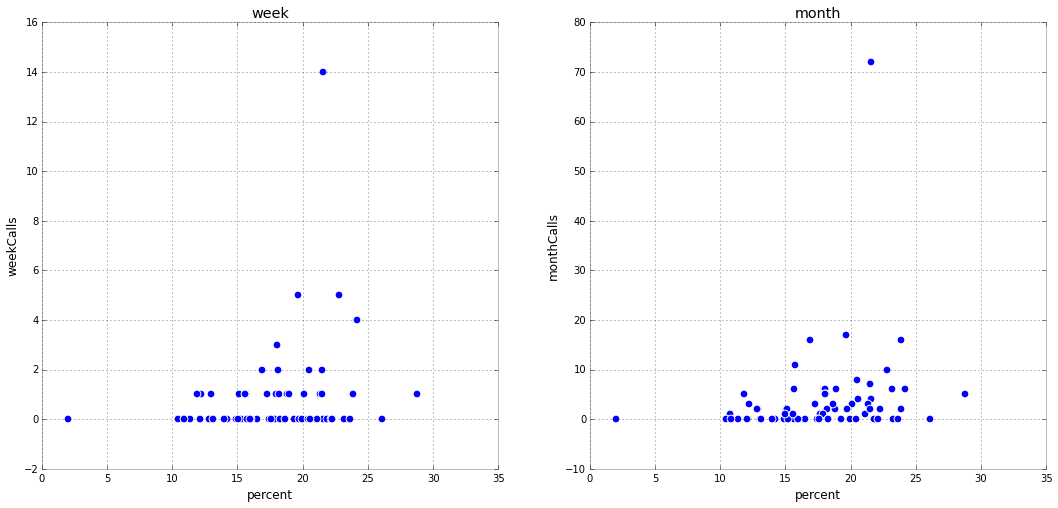

In [166]:
fig, axes = plt.subplots(1,2, figsize=(18,8))

d.plot(kind='scatter', x='percent',y='weekCalls',ax=axes[0],title='week', s=60);
d.plot(kind='scatter', x='percent',y='monthCalls',ax=axes[1],title='month', s=60);
plt.savefig(PARQA + 'parqa/inspections/litter.png')